In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
import torch
%matplotlib inline

In [3]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [14]:
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape:
        size = shape
        
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = in_transform(image).unsqueeze(0)
    return image

In [34]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [35]:
content = load_image('./data/Images/City.jpg').to('cpu')
style = load_image('./data/Images/StarryNight.jpg',shape=content.shape[-2:]).to('cpu')

(-0.5, 599.5, 399.5, -0.5)

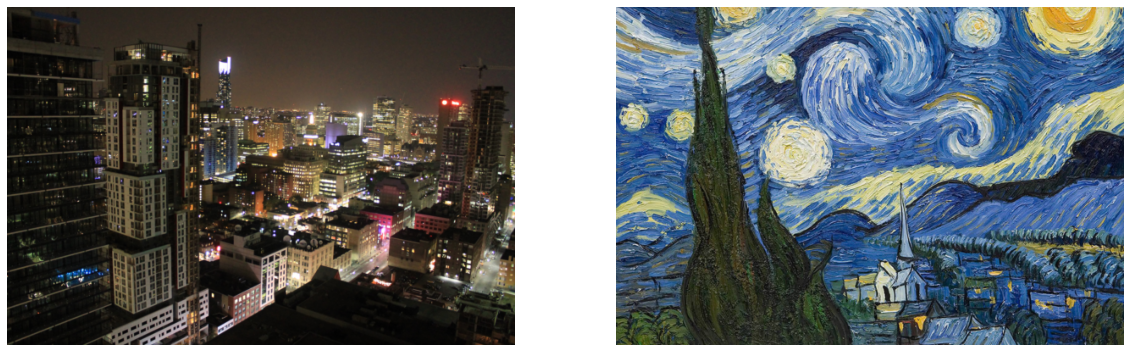

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [54]:
def get_features(image, model):
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',  # for content
        '28': 'conv5_1'
    }
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features

In [55]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [56]:
def gram_matrix(tensor):
    _,d,h,w = tensor.size()
    tensor = tensor.view(d,h*w)
    gram = torch.mm(tensor,tensor.t())
    return gram 

In [57]:
style_grams = {
    layer: gram_matrix(style_features[layer])
    for layer in style_features
}

In [58]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.20,
    'conv4_1': 0.20,
    'conv5_1': 0.20
}
content_weight = 1.0
style_weight = 1e6

In [59]:
target = content.clone().requires_grad_(True).to('cpu')

In [66]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300
counter = 0

Total Loss:  791731.1875
Iterations:  300


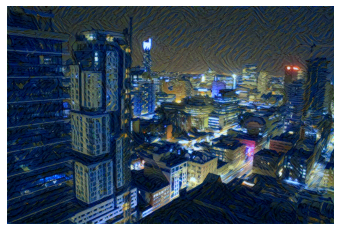

Total Loss:  563462.5
Iterations:  600


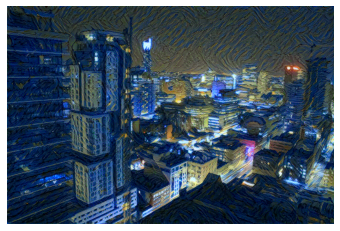

Total Loss:  423623.46875
Iterations:  900


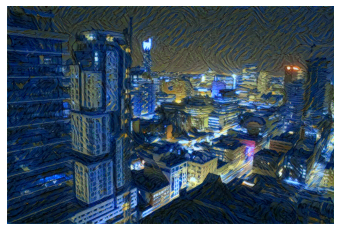

Total Loss:  321411.8125
Iterations:  1200


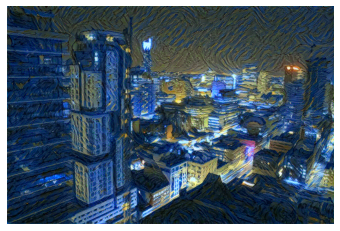

Total Loss:  244129.703125
Iterations:  1500


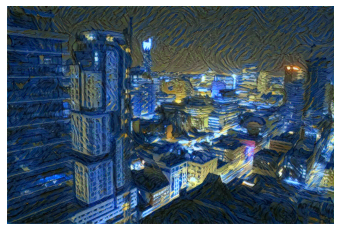

Total Loss:  185008.0625
Iterations:  1800


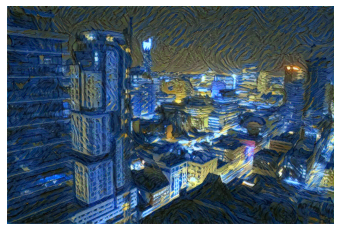

IndexError: index 300 is out of bounds for axis 0 with size 300

In [68]:
for ii in range(1, steps + 1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2).to('cpu')
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        _,d,h,w = target_feature.shape
        style_loss += layer_style_loss/ (d*h*w)
    total_loss = content_loss*content_weight + style_loss*style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if ii % show_every ==0:
        print('Total Loss: ', total_loss.item())
        print('Iterations: ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
        
        
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter +=1
    